In [1]:
import numpy as np
import math
import gtsam
from perseus.smoother.factors import PoseDynamicsFactor, ConstantVelocityFactor
import json
from gtsam.symbol_shorthand import X, V, W
import gtsam_unstable
import kornia
import time
%load_ext autoreload
%autoreload 2

In [96]:
# Quick example: 3D pose estimation with constant twist scenario.


# Setup scenario.
vel = np.array([0.1, 0, 0])
ang_vel = np.array([math.radians(30), -math.radians(30), 0])
vel_cov = np.array([1e-1, 1e-1, 1e-1])
ang_vel_cov = np.array([1e-1, 1e-1, 1e-1])
noisy_vel = vel + np.sqrt(vel_cov) * np.random.randn(3)
noisy_ang_vel = ang_vel + np.sqrt(ang_vel_cov) * np.random.randn(3)

# Create random initial pose.
prior_cov = np.diag(np.array([1e-1, 1e-1, 1e-1, 1e0, 1e0, 1e0]))
init_pose = gtsam.Pose3().expmap(np.linalg.cholesky(prior_cov) @ np.random.randn(6))

# Create process and measurement noises.
process_noise_pose = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-3] * 6))
process_noise_vel = gtsam.noiseModel.Diagonal.Sigmas(2 * vel_cov)
process_noise_ang_vel = gtsam.noiseModel.Diagonal.Sigmas(ang_vel_cov)
meas_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-1, 1e-1, 1e-1, 1e-1, 1e-1, 1e-1]))

# Create scenario.
scenario = gtsam.ConstantTwistScenario(noisy_ang_vel, noisy_vel, init_pose)
dt = 1e-1
n_steps = 75

# Create a factor graph
graph = gtsam.NonlinearFactorGraph()
initial_estimate = gtsam.Values()

# Create ISAM.
parameters = gtsam.ISAM2Params()
isam = gtsam.ISAM2(parameters)

# Create a prior on the initial position
prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.sqrt(np.diag(prior_cov)))
graph.push_back(gtsam.PriorFactorPose3(X(0), gtsam.Pose3(), prior_noise))

# Create a prior on the initial velocity
prior_velocity = gtsam.noiseModel.Diagonal.Sigmas(np.sqrt(vel_cov))
graph.push_back(gtsam.PriorFactorVector(V(0), vel, prior_velocity))

# Create a prior on the initial angular velocity
prior_angular_velocity = gtsam.noiseModel.Diagonal.Sigmas(np.sqrt(ang_vel_cov))
graph.push_back(gtsam.PriorFactorVector(W(0), ang_vel, prior_angular_velocity))

# Initialize values with the prior.
initial_estimate.insert(X(0), init_pose)
initial_estimate.insert(V(0), vel)
initial_estimate.insert(W(0), ang_vel)

# Solve to check we can recover the prior.
isam.update(graph, initial_estimate)
result = isam.calculateEstimate()
initial_estimate.clear()

noisy_poses = []

def add_factors(graph, initial_estimate, ii):
    curr_time = ii * dt

    # Simulate dynamics.
    pose = scenario.pose(curr_time)

    # Add a random measurement.
    noisy_pose = pose.compose(gtsam.Pose3().expmap(np.sqrt(meas_noise.sigmas()) * np.random.randn(6)))
    noisy_poses.append(noisy_pose)

    # Update the initial values.
    initial_estimate.insert(X(ii), noisy_pose)
    initial_estimate.insert(V(ii), result.atVector(V(ii-1)))
    initial_estimate.insert(W(ii), result.atVector(W(ii-1)))

    # Create a dynamics factor and add it to the graph.
    dynamics_factor = PoseDynamicsFactor(X(ii-1), W(ii-1), V(ii-1), X(ii), process_noise_pose, dt)
    graph.push_back(dynamics_factor)

    # Create a constant velocity factor and add it to the graph.
    velocity_factor = ConstantVelocityFactor(V(ii-1), V(ii), process_noise_vel)
    graph.push_back(velocity_factor)

    # Create a constant angular velocity factor and add it to the graph.
    angular_velocity_factor = ConstantVelocityFactor(W(ii-1), W(ii), process_noise_ang_vel)
    graph.push_back(angular_velocity_factor)

    # Create a measurement factor and add it to the graph.
    meas_factor = gtsam.PriorFactorPose3(X(ii), noisy_pose, meas_noise)
    graph.push_back(meas_factor)

# Run loop to simulate the scenario.
for ii in range(1, n_steps):
    
    # Add new factors to graph
    %time add_factors(graph, initial_estimate, ii)

    # # Update the ISAM.
    %time isam.update(graph, initial_estimate)
    %time result = isam.calculateEstimate()
    initial_estimate.clear()

result = isam.calculateEstimate()
    


CPU times: user 91 µs, sys: 7 µs, total: 98 µs
Wall time: 89.4 µs
CPU times: user 373 µs, sys: 31 µs, total: 404 µs
Wall time: 313 µs
CPU times: user 15 µs, sys: 2 µs, total: 17 µs
Wall time: 18.6 µs
CPU times: user 100 µs, sys: 8 µs, total: 108 µs
Wall time: 86.3 µs
CPU times: user 1.25 ms, sys: 0 ns, total: 1.25 ms
Wall time: 1e+03 µs
CPU times: user 20 µs, sys: 0 ns, total: 20 µs
Wall time: 22.9 µs
CPU times: user 94 µs, sys: 0 ns, total: 94 µs
Wall time: 83.4 µs
CPU times: user 1.3 ms, sys: 0 ns, total: 1.3 ms
Wall time: 1.01 ms
CPU times: user 22 µs, sys: 0 ns, total: 22 µs
Wall time: 25 µs
CPU times: user 75 µs, sys: 0 ns, total: 75 µs
Wall time: 79.2 µs
CPU times: user 1.23 ms, sys: 0 ns, total: 1.23 ms
Wall time: 1.23 ms
CPU times: user 25 µs, sys: 0 ns, total: 25 µs
Wall time: 27.9 µs
CPU times: user 75 µs, sys: 0 ns, total: 75 µs
Wall time: 79.2 µs
CPU times: user 1.8 ms, sys: 0 ns, total: 1.8 ms
Wall time: 1.8 ms
CPU times: user 25 µs, sys: 0 ns, total: 25 µs
Wall time: 27.4

In [97]:
# Plot estimated poses.
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(n_steps), y=[result.atPose3(X(ii)).translation()[0] for ii in range(n_steps)], mode='lines+markers', name='x'))
fig.add_trace(go.Scatter(x=np.arange(n_steps), y=[scenario.pose(dt * ii).translation()[0] for ii in range(n_steps)], mode='lines+markers', name='x_true'))



fig.add_trace(go.Scatter(x=np.arange(n_steps), y=[noisy_poses[ii].translation()[0] for ii in range(n_steps-1)], mode='markers', name='x_meas'))
fig.show()

In [98]:
# Plot estimated velocities.
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(n_steps), y=[result.atVector(V(ii))[0] for ii in range(n_steps)], mode='lines+markers', name='vx'))
fig.add_trace(go.Scatter(x=np.arange(n_steps), y=[scenario.velocity_n(dt * ii)[0] for ii in range(n_steps)], mode='lines+markers', name='vx_true'))


fd_vels = []
# Compute finite differences.
for tt in range(1, n_steps):
    vel_hat = (result.atPose3(X(tt)).translation() - result.atPose3(X(tt-1)).translation()) / dt
    fd_vels.append(vel_hat)

fd_vels = np.stack(fd_vels)

fig.add_trace(go.Scatter(x=np.arange(n_steps-1), y=fd_vels[:, 0], mode='lines+markers', name='vx_fd'))

In [99]:
# Check dynamics error is functionally zero. 
ii = 1
dynamics_factor = PoseDynamicsFactor(X(ii), W(ii), V(ii), X(ii+1), process_noise_pose, dt)
values = gtsam.Values()
values.insert(X(ii), result.atPose3(X(ii)))
values.insert(V(ii), result.atVector(V(ii)))
values.insert(W(ii), result.atVector(W(ii)))
values.insert(X(ii+1), result.atPose3(X(ii+1)))
error_factor = PoseDynamicsFactor.error_func(dynamics_factor, values, dt=dt)

values_fd = gtsam.Values()
values_fd.insert(X(ii), result.atPose3(X(ii)))
values_fd.insert(V(ii), fd_vels[ii])
values_fd.insert(W(ii), result.atVector(W(ii)))
values_fd.insert(X(ii+1), result.atPose3(X(ii+1)))
error_factor_fd = PoseDynamicsFactor.error_func(dynamics_factor, values_fd, dt=dt)

error_factor, error_factor_fd

(array([-0.00114413,  0.00246691,  0.00096158,  0.0088228 , -0.02121089,
        -0.00831767]),
 array([-0.00114413,  0.00246691,  0.00096158,  0.00706541, -0.02052121,
        -0.0048119 ]))

In [100]:
# Plot estimated trajectory + measurements + ground truth.
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=[result.atPose3(X(ii)).translation()[0] for ii in range(n_steps)], 
                           y=[result.atPose3(X(ii)).translation()[1] for ii in range(n_steps)], 
                           z=[result.atPose3(X(ii)).translation()[2] for ii in range(n_steps)], 
                           mode='lines', name='x_est'))
fig.add_trace(go.Scatter3d(x=[scenario.pose(dt * ii).translation()[0] for ii in range(n_steps)],
                            y=[scenario.pose(dt * ii).translation()[1] for ii in range(n_steps)],
                            z=[scenario.pose(dt * ii).translation()[2] for ii in range(n_steps)],
                            mode='lines', name='x_true'))
fig.add_trace(go.Scatter3d(x=[noisy_poses[ii].translation()[0] for ii in range(n_steps-1)],
                            y=[noisy_poses[ii].translation()[1] for ii in range(n_steps-1)],
                            z=[noisy_poses[ii].translation()[2] for ii in range(n_steps-1)],
                            mode='markers', name='x_meas'))
fig.show()

In [ ]:
# Check the sim dynamics.
dt = 1e-2
pose0 = scenario.pose(0)
pose1 = scenario.pose(dt)

# Pull out velocities.
vel0 = scenario.velocity_n(0)
ang_vel0 = pose0.rotation().rotate(scenario.omega_b(0))

twist0_n = np.concatenate([ang_vel0, vel0])
pose_increment = gtsam.Pose3().Expmap(twist0_n * dt)

# Check the pose increment.
print(pose0 * pose_increment, pose1)

R: [
	0.965707, -0.0402507, -0.256497;
	0.107918, 0.960755, 0.255544;
	0.236145, -0.274461, 0.932152
]
t: -0.240184  0.594686 -0.703984
 R: [
	0.965267, -0.0385839, -0.258401;
	0.106437, 0.961315, 0.254058;
	0.238602, -0.272737, 0.932032
]
t: -0.240764  0.594854 -0.705702



In [116]:
import gtsam_unstable

n_steps = 25
lag = 2.0
smoother = gtsam_unstable.BatchFixedLagSmoother(lag)
new_factors = gtsam.NonlinearFactorGraph()
new_values = gtsam.Values()
new_timestamps = gtsam_unstable.FixedLagSmootherKeyTimestampMap()

# First setup the prior factors.
# Create a prior on the initial position
prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.sqrt(np.diag(prior_cov)))
new_factors.push_back(gtsam.PriorFactorPose3(X(0), gtsam.Pose3(), prior_noise))

# Create a prior on the initial velocity
prior_velocity = gtsam.noiseModel.Diagonal.Sigmas(np.sqrt(vel_cov))
new_factors.push_back(gtsam.PriorFactorVector(V(0), vel, prior_velocity))

# Create a prior on the initial angular velocity
prior_angular_velocity = gtsam.noiseModel.Diagonal.Sigmas(np.sqrt(ang_vel_cov))
new_factors.push_back(gtsam.PriorFactorVector(W(0), ang_vel, prior_angular_velocity))

# Create measurement noise.
meas_noise = gtsam.noiseModel.Diagonal.Sigmas(1e-1 * np.array([1e-1, 1e-1, 1e-1, 1e-1, 1e-1, 1e-1]))

# Initialize values with the prior.
new_values.insert(X(0), gtsam.Pose3())
new_values.insert(V(0), vel)
new_values.insert(W(0), ang_vel)
new_timestamps.insert((X(0), 0.0))
new_timestamps.insert((V(0), 0.0))
new_timestamps.insert((W(0), 0.0))

pose_ests = []
measurements = []

for ii in range(1, n_steps):
    curr_time = ii * dt

    # Assign timestame to the current values.
    new_timestamps.insert((X(ii), curr_time))
    new_timestamps.insert((V(ii), curr_time))
    new_timestamps.insert((W(ii), curr_time))

    # Add new factors to graph
    # Simulate dynamics.
    pose = scenario.pose(curr_time)

    # Add a random measurement.
    noisy_pose = pose.compose(gtsam.Pose3().expmap(meas_noise.sigmas() * np.random.randn(6)))

    # Update the initial values.
    new_values.insert(X(ii), noisy_pose)
    if ii > 1:
        new_values.insert(V(ii), smoother.calculateEstimate().atVector(V(ii-1)))
        new_values.insert(W(ii), smoother.calculateEstimate().atVector(W(ii-1)))
    else:
        new_values.insert(V(ii), vel)
        new_values.insert(W(ii), ang_vel)

    # Create a dynamics factor and add it to the graph.
    dynamics_factor = PoseDynamicsFactor(X(ii-1), V(ii-1), W(ii-1), X(ii), process_noise_pose, dt)
    new_factors.push_back(dynamics_factor)

    # Create a constant velocity factor and add it to the graph.
    velocity_factor = ConstantVelocityFactor( V(ii-1), V(ii), process_noise_vel)
    new_factors.push_back(velocity_factor)

    # Create a constant angular velocity factor and add it to the graph.
    angular_velocity_factor = ConstantVelocityFactor(W(ii-1), W(ii), process_noise_ang_vel)
    new_factors.push_back(angular_velocity_factor)

    # Create a measurement factor and add it to the graph.
    meas_factor = gtsam.PriorFactorPose3(X(ii), noisy_pose, meas_noise)
    new_factors.push_back(meas_factor)

    # Update the smoother.
    %time smoother.update(new_factors, new_values, new_timestamps)
    # %time smoother.calculateEstimate().atPose3(X(ii))
    new_timestamps.clear()
    new_factors.resize(0)
    new_values.clear()

    # Store the pose estimate.
    pose_ests.append(smoother.calculateEstimate().atPose3(X(ii)))
    measurements.append(noisy_pose)



CPU times: user 1.99 ms, sys: 467 µs, total: 2.45 ms
Wall time: 1.87 ms
CPU times: user 1.37 ms, sys: 0 ns, total: 1.37 ms
Wall time: 1.32 ms
CPU times: user 3.38 ms, sys: 0 ns, total: 3.38 ms
Wall time: 3.39 ms
CPU times: user 1.92 ms, sys: 0 ns, total: 1.92 ms
Wall time: 1.93 ms
CPU times: user 5.47 ms, sys: 0 ns, total: 5.47 ms
Wall time: 5.4 ms
CPU times: user 6.15 ms, sys: 0 ns, total: 6.15 ms
Wall time: 5.91 ms
CPU times: user 7.21 ms, sys: 0 ns, total: 7.21 ms
Wall time: 7.21 ms
CPU times: user 8.27 ms, sys: 0 ns, total: 8.27 ms
Wall time: 8.28 ms
CPU times: user 4.15 ms, sys: 33 µs, total: 4.19 ms
Wall time: 4.19 ms
CPU times: user 10.5 ms, sys: 0 ns, total: 10.5 ms
Wall time: 10.5 ms
CPU times: user 5.2 ms, sys: 0 ns, total: 5.2 ms
Wall time: 5.2 ms
CPU times: user 10.5 ms, sys: 0 ns, total: 10.5 ms
Wall time: 10.5 ms
CPU times: user 14.4 ms, sys: 0 ns, total: 14.4 ms
Wall time: 14.4 ms
CPU times: user 6.79 ms, sys: 0 ns, total: 6.79 ms
Wall time: 6.8 ms
CPU times: user 16.7 m

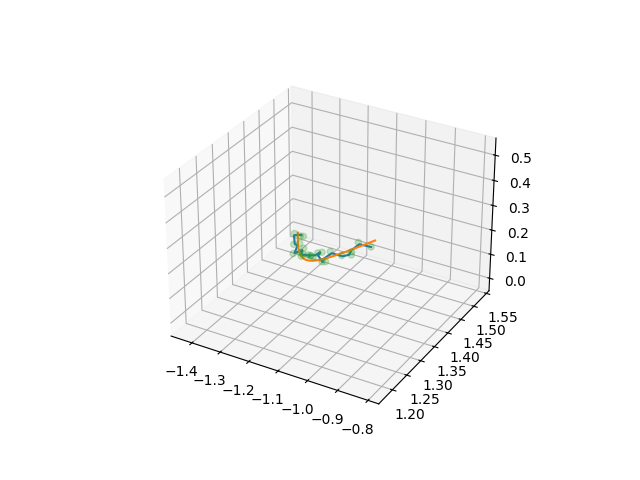

In [115]:
import matplotlib.pyplot as plt
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the ground truth.
np_pose_ests = np.array([pose_ests[ii].translation() for ii in range(len(pose_ests))])
ax.plot(np_pose_ests[:, 0], np_pose_ests[:, 1], np_pose_ests[:, 2], label='Estimated trajectory')

# Scatter the measurements
np_measurements = np.array([measurements[ii].translation() for ii in range(len(measurements))])
ax.scatter(np_measurements[:, 0], np_measurements[:, 1], np_measurements[:, 2], label='Measurements', c="C2", alpha=0.25)

# Plot the ground truth.
poses = np.array([scenario.pose(ii * dt).translation() for ii in range(n_steps)])
ax.plot(poses[:, 0], poses[:, 1], poses[:, 2], label='Ground truth trajectory')



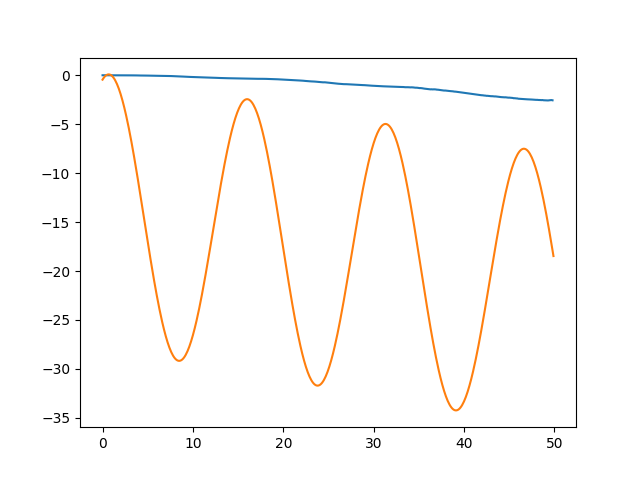

In [70]:
plt.close("all")
plt.plot(np.arange(n_steps-1)*dt, np_pose_ests[:, 0], label='x')
plt.plot(np.arange(n_steps)*dt, poses[:, 0], label='x_true')
plt.show()

In [ ]:
from typing import List, Optional

class DynamicsFactor(gtsam.CustomFactor):
    def __init__(self, noise_model: gtsam.noiseModel, pose1: int, ang_vel1: int, vel1: int, pose2: int, dt: float):
        super().__init__(noise_model, [pose1, ang_vel1, vel1, pose2], self.error_func)
        self.dt = dt

    def error_func(self, v: gtsam.Values, H: Optional[List[np.ndarray]] = None) -> np.ndarray:
        pose1 = v.atPose3(self.keys()[0])
        ang_vel1 = v.atVector(self.keys()[1])
        vel1 = v.atVector(self.keys()[2])
        pose2 = v.atPose3(self.keys()[3])

        if H:
            perturbation_jac = np.zeros((6, 6), dtype=np.float64, order='F')

            # Case 1: JUST LOG OF pose1.
            # error = pose1.Logmap(pose1, H[0])

            # Case 2: Log of pose1.inverse.
            # pinv = pose1.inverse(H[0])
            # H1 = np.zeros((6,6), order="F")
            # error = pinv.Logmap(pinv, H1)

            # H[0] = H1 @ H[0] # Chain rule: dlog * dinv

            # Case 3: Log of pose1.between(pose2).
            # pinv = pose1.inverse(H[0])
                 # rel_pose = pose1.compose(pose2, H0, H1)
            # error = rel_pose.Logmap(rel_pose, H2)
            # error = pose1.Logmap(pose1, H[0])

            # print(H0, H1, H2)


            # H[0] = H2 @ H0
            # H[-1] = H2 @ H1
            
            dpred_dx0 = np.zeros((6,6), order="F")
            dpred_dtwist = np.zeros((6,6), order="F")
            drel_dpred = np.zeros((6,6), order="F")
            drel_dpose2 = np.zeros((6,6), order="F")

            pose_increment = pose1.Expmap(np.concatenate([dt*ang_vel1, dt*vel1]), perturbation_jac)
            pred_pose = pose1.compose(pose_increment, dpred_dx0, dpred_dtwist)

       

            rel_pose = pred_pose.between(pose2, drel_dpred, drel_dpose2)
            error = rel_pose.Logmap(rel_pose)
            dlog = rel_pose.LogmapDerivative(rel_pose)

            H[0] = dlog @ drel_dpred @ dpred_dx0
            
            derr_dtwist = dt * dlog @ drel_dpred @ dpred_dtwist @  perturbation_jac
            H[1] = derr_dtwist[:, :3]
            H[2] = derr_dtwist[:, 3:]

            H[3] = dlog @ drel_dpose2

            # error = pinv.Logmap(pinv, H[-1])

            # H[-1] = H[-1] @ H[0]

            # H[-1] = pose2.LogmapDerivative(rel_pose)
            # H[-1] = pose1.LogmapDerivative(pose1)
            return error


        

        # return error
initial_estimate = gtsam.Values()
rand_pose1 = gtsam.Pose3().expmap(np.linalg.cholesky(prior_cov) @ np.random.randn(6))
rand_pose2 = gtsam.Pose3().expmap(np.linalg.cholesky(prior_cov) @ np.random.randn(6))
rand_vel = np.random.randn(3)
rand_ang_vel = np.random.randn(3)

initial_estimate.insert(X(0), rand_pose1)
initial_estimate.insert(V(0), rand_vel)
initial_estimate.insert(W(0), rand_ang_vel)
initial_estimate.insert(X(1), rand_pose2)

# initial_estimate.insert(X(0), init_pose)
# initial_estimate.insert(X(1), init_pose.expmap(np.concatenate([dt*ang_vel, dt*vel])))
# initial_estimate.insert(V(0), vel)
# initial_estimate.insert(W(0), ang_vel)
# initial_estimate.insert(X(1), init_pose)

jac_list = [np.zeros((6,6), order="F"), np.zeros((6,3), order="F"), np.zeros((6,3), order="F"), np.zeros((6,6), order="F")]
dyn_factor = DynamicsFactor(gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-1, 1e-1, 1e-1, 1e-1, 1e-1, 1e-1])), X(0), W(0), V(0), X(1), 1e-1)
%time gtsam_error = dyn_factor.error_func(initial_estimate, jac_list)

In [ ]:
import pypose as pp
import torch

X0 = initial_estimate.atPose3(X(0))
X1 = initial_estimate.atPose3(X(1))
W0 = initial_estimate.atVector(W(0))
V0 = initial_estimate.atVector(V(0))

x0 = pp.mat2SE3(X0.matrix().astype(np.float64))
x1 = pp.mat2SE3(X1.matrix().astype(np.float64))
w0 = torch.tensor(W0.astype(np.float64))
v0 = torch.tensor(V0.astype(np.float64))
# err = pp.mat2SE3(gtsam_error.matrix().astype(np.float64))
err = torch.tensor(gtsam_error.astype(np.float64))

# x0 = pp.randn_SE3()
# x1 = pp.randn_SE3()
# w0 = torch.randn(3)
# v0 = torch.randn(3)

def flip(x):
    return torch.cat([x[3:], x[:3]])

def error(x0, w0, v0, x1, dx0, dw0, dv0, dx1):
    # return x0.Log()
    # return x0.Inv().Log()
    # return (x0 @ x1).Log()
    x0_perturbed = x0 @ pp.se3(flip(dx0)).Exp()
    v0_perturbed = v0 + dv0
    w0_perturbed = w0 + dw0
    x1_perturbed = x1 @ pp.se3(flip(dx1)).Exp()

    pred_pose = x0_perturbed @ pp.se3(dt * torch.cat([v0_perturbed, w0_perturbed])).Exp()
    rel_pose = pred_pose.Inv() @ x1_perturbed
    return flip(rel_pose.Log())
    # return (x0.Inv() @ x1).Log()
    # with pp.retain_ltype():
    #     pred_pose = x0 @ pp.se3(dt * torch.cat([v0, w0])).Exp()

    #     err = (pred_pose.Inv() @ x1).Log()

    #     return err

dx0 = torch.zeros(6, dtype=torch.float64)
dw0 = torch.zeros(3, dtype=torch.float64)
dv0 = torch.zeros(3, dtype=torch.float64)
dx1 = torch.zeros(6, dtype=torch.float64)

e = error(x0, w0, v0, x1, dx0, dw0, dv0, dx1)
e, err

# def to_gtsam(jac: torch.Tensor) -> torch.tensor:
#     flipped_inds = torch.cat((torch.arange(3,6), torch.arange(3)))
#     return jac[flipped_inds, :][:, flipped_inds]

# index = -1
# vars = [x0, w0, v0, x1]

# def adj_mat(x: pp.SE3_type) -> torch.Tensor:
#     return torch.cat([torch.cat([x.rotation().matrix(), pp.vec2skew(x.translation()) @ x.rotation().matrix()], dim=-1), torch.cat([torch.zeros_like(x.rotation().matrix()), x.rotation().matrix()], dim=-1)], dim=-2)

## Camera scratch

In [ ]:
from perseus.smoother.factors import KeypointProjectionFactor
import torch

from perseus.detector.data import KeypointDataset, KeypointDatasetConfig
from perseus.detector.models import KeypointCNN
import pypose as pp

# Load model.
model = KeypointCNN()
model.load_state_dict(torch.load("outputs/models/ibkvjlvb.pth"))
model.eval()

# Load data.
dataset_cfg = KeypointDatasetConfig()
dataset = KeypointDataset(dataset_cfg, train=False)
                                           

Images shape: (491, 24, 256, 256, 3)


In [ ]:
# Pull random trajectory and image from the dataset.
data = dataset[0]

# Extract parameters from intrinsics.
intrinsics = data["camera_intrinsics"]
fx = intrinsics[0, 0]
fy = intrinsics[1, 1]
cx = intrinsics[0, 2]
cy = intrinsics[1, 2]
s = 0.0

# Create a camera calibration.
calibration = gtsam.Cal3_S2(fx, fy, s, cx, cy)

# Load ground-truth keypoints.
object_scale = data["object_scale"]
keypoints_object_frame = torch.tensor(json.load(open("data/2024-01-12_17-21-39/mjc_keypoints.json"))).float() * object_scale

# Run inference to get predicted keypoints.
pred_keypoints = model(data["image"].unsqueeze(0)).squeeze(0).reshape(-1, 2)
pred_keypoints = kornia.geometry.denormalize_pixel_coordinates(pred_keypoints, model.H, model.W)
gt_keypoints = data["pixel_coordinates"].clone()

# Create noise model for the keypoint projection factor.
noise_model = gtsam.noiseModel.Isotropic.Sigma(2, 5.0)

# Create a keypoint projection factor.
keypoint_factor = KeypointProjectionFactor(X(0), noise_model, calibration, pred_keypoints.detach().numpy()[0], keypoints_object_frame.numpy()[0])

# Create initial estimate.
initial_estimate = gtsam.Values()
object_pose = data["object_pose"].double()
camera_pose = data["camera_pose"].double()
# Convert to GTSAM pose.
PP_TO_GTSAM = pp.SE3(torch.cat((torch.zeros(3,), pp.euler2SO3(np.array([np.pi, 0, 0])).tensor())))

object_pose = PP_TO_GTSAM @ camera_pose.Inv() @ object_pose 

initial_estimate.insert(X(0), gtsam.Pose3(object_pose.matrix()))

# Compute error.
keypoint_factor.error_func(initial_estimate, camera_intrinsics=calibration, keypoint_measurement=pred_keypoints.detach().numpy()[0], point_body_frame=keypoints_object_frame.numpy()[0])

array([-2.01757158, -0.34382048])

In [ ]:
# Check Jacobians against pypose.
def flip(x):
    return torch.cat([x[3:], x[:3]])

def pypose_error(x: pp.SE3_type,  dx: torch.Tensor):
    x_perturbed = x @ pp.se3(flip(dx)).Exp()
    keypoint_camera_frame = x_perturbed.Act(keypoints_object_frame[0].double())
    keypoint_pixel = pp.point2pixel(keypoint_camera_frame, data["camera_intrinsics"].double())

    # Compute error.
    return keypoint_pixel - pred_keypoints[0]

camera_pose = data["camera_pose"].double()
object_pose = data["object_pose"].double()
pp_error = pypose_error(PP_TO_GTSAM @ camera_pose.Inv() @ object_pose, torch.zeros(6, dtype=torch.float64))
gtsam_error = KeypointProjectionFactor.error_func(keypoint_factor, initial_estimate, camera_intrinsics=calibration, point_body_frame=keypoints_object_frame.numpy()[0], keypoint_measurement=pred_keypoints.detach().numpy()[0])

pp_error, gtsam_error

# Now, compute the Jacobians.
pp_jacobian = pp.func.jacrev(pypose_error, 1)(PP_TO_GTSAM @ camera_pose.Inv() @ object_pose, torch.zeros(6, dtype=torch.float64))

# Create a Jacobian container.
jac_list = [np.zeros((2, 6), order="F"), np.zeros((2, 6), order="F")]
gtsam_error = KeypointProjectionFactor.error_func(keypoint_factor, initial_estimate, jac_list, camera_intrinsics=calibration, point_body_frame=keypoints_object_frame.numpy()[0], keypoint_measurement=pred_keypoints.detach().numpy()[0])

pp_jacobian, jac_list[0] 
# keypoint_camera_frame = (camera_pose.Inv() @ object_pose).Act(keypoints_object_frame[0].double())
# pred_keypoints[0], pp.point2pixel(keypoint_camera_frame, data["camera_intrinsics"].double())

# gtsam_error, pp_error

# # First check things aren't insane.
# # camera_pose.Inv() @ object_pose
# gtsam_pose = gtsam.Pose3((PP_TO_GTSAM @ camera_pose.Inv() @ object_pose).matrix())
# gtsam_keypoint_loc = gtsam_pose.transformFrom(keypoints_object_frame[0].double())
# gtsam_pixel = gtsam.PinholeCameraCal3_S2(gtsam.Pose3(), calibration).project(gtsam_keypoint_loc)

# # Check vs pypose act.
# pp_pose = PP_TO_GTSAM @ camera_pose.Inv() @ object_pose
# pp_keypoint_loc = pp_pose.Act(keypoints_object_frame[0].double())
# pp_pixel = pp.point2pixel(pp_keypoint_loc, torch.diag(torch.tensor([1., 1., 1])).double() @ data["camera_intrinsics"].double())

# gtsam_pixel, pp_pixel
pp_error, gtsam_error

# # Check pypose projection.
# # data["camera_intrinsics"]
# pp.point2pixel(torch.tensor([1, 1, -6]).double(), data["camera_intrinsics"].double()),

(tensor([-2.0176, -0.3438], dtype=torch.float64, grad_fn=<SubBackward0>),
 array([-2.01757158, -0.34382048]))

In [ ]:
# Check timing.
gtsam_factor = gtsam.GenericProjectionFactorCal3_S2(pred_keypoints.detach().numpy()[0], noise_model, X(0), V(0), calibration)

initial_estimate = gtsam.Values()
initial_estimate.insert(X(0), gtsam.Pose3(object_pose.matrix()))
initial_estimate.insert(V(0), np.zeros(3))

%timeit gtsam_error = gtsam_factor.error(initial_estimate)

# Check python error
%timeit keypoint_factor.error(initial_estimate)

2.6 µs ± 108 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
6.62 µs ± 205 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [ ]:
# Setup tracking example from sim datset.
traj_index = 0
traj = dataset.get_trajectory(traj_index)

# Create a camera calibration.
intrinsics = traj["camera_intrinsics"][0]
fx = intrinsics[0, 0]
fy = intrinsics[1, 1]
cx = intrinsics[0, 2]
cy = intrinsics[1, 2]
s = 0.0

# Define kubric frame rate and related dt.
kubric_fps = 12
dt = 1.0 / kubric_fps

# Create a camera calibration.
calibration = gtsam.Cal3_S2(fx, fy, s, cx, cy)

# Load ground-truth keypoints.
object_scale = traj["object_scales"][0]
keypoints_object_frame = torch.tensor(json.load(open("data/2024-01-12_17-21-39/mjc_keypoints.json"))).float() * object_scale

# Compute ground-truth initial pose.
object_pose = traj["object_poses"][0].double()
camera_pose = traj["camera_poses"][0].double()
PP_TO_GTSAM = pp.SE3(torch.cat((torch.zeros(3,), pp.euler2SO3(np.array([np.pi, 0, 0])).tensor())))
gt_pose = PP_TO_GTSAM @ camera_pose.Inv() @ object_pose

# Run inference to get predicted keypoints.
pred_keypoints = model(traj["images"]).reshape(-1, model.n_keypoints, 2)
pred_keypoints = kornia.geometry.denormalize_pixel_coordinates(pred_keypoints, model.H, model.W)

# Create noise model for the keypoint projection factor.
keypoint_noise_model = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e0, 1e0]))

# Setup factor graph and prior.
graph = gtsam.NonlinearFactorGraph()
initial_estimate = gtsam.Values()

# Create a prior on the initial position
prior_cov = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e0, 1e0, 1e0, 1e0, 1e0, 1e0])) 
# prior_mean = gtsam.Pose3(gt_pose.matrix())
prior_mean = gtsam.Pose3(gt_pose.matrix()).expmap(prior_cov.sigmas() * np.random.randn(6))


# Create a prior on the initial position
prior_pose_factor = gtsam.PriorFactorPose3(X(0), prior_mean, prior_cov)
initial_estimate.insert(X(0), prior_mean)
graph.push_back(prior_pose_factor)

# Create a prior on the initial velocity
prior_velocity = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-1, 1e-1, 1e-1]))
initial_estimate.insert(V(0), np.array([0, 0, 0]))
graph.push_back(gtsam.PriorFactorVector(V(0), initial_estimate.atVector(V(0)), prior_velocity))

# Create a prior on the initial angular velocity
prior_angular_velocity = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-1, 1e-1, 1e-1]))
initial_estimate.insert(W(0), np.array([0, 0, 0]))
graph.push_back(gtsam.PriorFactorVector(W(0), initial_estimate.atVector(W(0)), prior_angular_velocity))

# Define process noise.
process_noise_pose = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-3, 1e-3, 1e-3, 1e-3, 1e-3, 1e-3]))
process_noise_vel = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-1, 1e-1, 1e-1]))
process_noise_ang_vel = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-1, 1e-1, 1e-1]))

keypoint_factor_list = []

# Add a factor for each keypoint.
for kk in range(model.n_keypoints):
    # Create a keypoint projection factor.
    keypoint_factor = KeypointProjectionFactor(X(0), keypoint_noise_model, calibration, pred_keypoints[0, kk].detach().numpy(), keypoints_object_frame[kk].numpy())

    keypoint_factor_list.append(keypoint_factor)

    # Add factor to graph.
    graph.push_back(keypoint_factor)

# Create a smoother object.
isam_params = gtsam.ISAM2Params()
isam_params.setRelinearizeThreshold(0.1)
# opt_params = gtsam.GaussNewtonParams()
# opt_params.setVerbosity('SUMMARY')
# isam_params.setOptimizationParams(opt_params)
isam = gtsam.ISAM2(isam_params)

# Solve the graph to start the pipeline.
isam.update(graph, initial_estimate)
result = isam.calculateEstimate()
initial_estimate.clear()


initial_estimate.clear()

# Store the cube poses.
cube_poses = []
start_iter = 1

# Loop through the trajectory, add factors, and incrementally perform inference.
for tt in range(traj["images"].shape[0]):
    # Loop through keypoints + add factors for each one.
    keypoint_factor_list = []
    for kk in range(model.n_keypoints):
        # Create a keypoint projection factor.
        keypoint_factor = KeypointProjectionFactor(X(tt), noise_model, calibration, pred_keypoints[tt, kk].detach().numpy(), keypoints_object_frame[kk].numpy())
        keypoint_factor_list.append(keypoint_factor)

        # Add factor to graph.
        graph.push_back(keypoint_factor)

    # Add dynamics factors.
    dynamics_factor = PoseDynamicsFactor(X(tt), V(tt), W(tt), X(tt+1), process_noise_pose, dt)
    graph.push_back(dynamics_factor)

    # Create a constant velocity factor and add it to the graph.
    velocity_factor = ConstantVelocityFactor(V(tt), V(tt+1), process_noise_vel)
    graph.push_back(velocity_factor)

    # Create a constant angular velocity factor and add it to the graph.
    angular_velocity_factor = ConstantVelocityFactor(W(tt), W(tt+1), process_noise_ang_vel)
    graph.push_back(angular_velocity_factor)

    # Store initial guesses for the next iteration.
    if tt > start_iter:
        initial_estimate.insert(X(tt+1), result.atPose3(X(tt)))
        initial_estimate.insert(V(tt+1), result.atVector(V(tt)))
        initial_estimate.insert(W(tt+1), result.atVector(W(tt)))

    else:
        initial_estimate.insert(X(tt+1), prior_mean)
        initial_estimate.insert(V(tt+1), np.array([0, 0, 0]))
        initial_estimate.insert(W(tt+1), np.array([0, 0, 0]))
    
    # Update the ISAM.
    if tt >= start_iter:
        isam.update(graph, initial_estimate)
        result = isam.calculateEstimate()
        initial_estimate.clear()

    # Store the result.
    cube_poses.append(result.atPose3(X(tt)))

# Store last pose.
cube_poses.append(result.atPose3(X(traj["images"].shape[0])))
[kk.error(result) for kk in keypoint_factor_list], 
# result.atPose3(X(0)), prior_mean, PP_TO_GTSAM @ camera_pose.Inv() @ object_pose

([6.4347358247235285,
  2.283245045509511,
  8.744074319363575,
  8.7032466222626,
  9.37201579977234,
  26.972799457655505,
  0.016594760142138388,
  8.728813149397546],)

In [ ]:
# Compute GT poses.
gt_poses = []
for tt in range(traj["images"].shape[0]):
    object_pose = traj["object_poses"][tt].double()
    camera_pose = traj["camera_poses"][tt].double()
    gt_poses.append(PP_TO_GTSAM @ camera_pose.Inv() @ object_pose)

In [ ]:
# Plot cube poses.  
from matplotlib import pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

smoothed_poses = np.stack([result.atPose3(X(ii)).translation() for ii in range(traj["images"].shape[0])])

# Plot the poses.
# np_cube_poses = np.array([smoothed_poses[ii].translation() for ii in range(len(smoothed_poses))])
ax.plot(smoothed_poses[:, 0], smoothed_poses[:, 1], smoothed_poses[:, 2], label='Estimated trajectory')
ax.plot(np.array([gt_pose.translation()[0] for gt_pose in gt_poses]), np.array([gt_pose.translation()[1] for gt_pose in gt_poses]), np.array([gt_pose.translation()[2] for gt_pose in gt_poses]), label='Ground truth trajectory')
ax.scatter(prior_mean.translation()[0], prior_mean.translation()[1], prior_mean.translation()[2], label='Prior', c="C3")

# Fixed-lag Smoother

In [ ]:
# Pick a trajectory from the dataset.
traj_index = np.random.randint(0, dataset.num_trajectories)
traj = dataset.get_trajectory(traj_index)

# Define kubric frame rate and related dt.
kubric_fps = 12
dt = 1.0 / kubric_fps


n_steps = traj["images"].shape[0]
lag = 5 * dt

# Create a fixed-lag smoother.
smoother = gtsam_unstable.BatchFixedLagSmoother(lag)
new_factors = gtsam.NonlinearFactorGraph()
new_values = gtsam.Values()
new_timestamps = gtsam_unstable.FixedLagSmootherKeyTimestampMap()

# Create a camera calibration.
intrinsics = traj["camera_intrinsics"][0]
fx = intrinsics[0, 0]
fy = intrinsics[1, 1]
cx = intrinsics[0, 2]
cy = intrinsics[1, 2]
s = 0.0

# Create a camera calibration.
calibration = gtsam.Cal3_S2(fx, fy, s, cx, cy)

# Load ground-truth keypoints.
object_scale = traj["object_scales"][0]
keypoints_object_frame = torch.tensor(json.load(open("data/2024-01-12_17-21-39/mjc_keypoints.json"))).float() * object_scale

# Compute ground-truth initial pose.
object_pose = traj["object_poses"][0].double()
camera_pose = traj["camera_poses"][0].double()
PP_TO_GTSAM = pp.SE3(torch.cat((torch.zeros(3,), pp.euler2SO3(np.array([np.pi, 0, 0])).tensor())))
gt_pose = PP_TO_GTSAM @ camera_pose.Inv() @ object_pose

# Run inference to get predicted keypoints.
pred_keypoints = model(traj["images"]).reshape(-1, model.n_keypoints, 2)
pred_keypoints = kornia.geometry.denormalize_pixel_coordinates(pred_keypoints, model.H, model.W)
cnn_times = []

# Create noise model for the keypoint projection factor.
keypoint_noise_model = gtsam.noiseModel.Diagonal.Sigmas(10 * np.array([1e0, 1e0]))


# Create a prior on the initial position
prior_pose_cov = gtsam.noiseModel.Diagonal.Sigmas(2.5 * np.array([1e0, 1e0, 1e0, 1e0, 1e0, 1e0])) 
prior_pose_mean = gtsam.Pose3(gt_pose.matrix()).expmap(prior_pose_cov.sigmas() * np.random.randn(6))

# Create a prior on the initial position
prior_pose_factor = gtsam.PriorFactorPose3(X(0), prior_pose_mean, prior_pose_cov)
new_factors.push_back(prior_pose_factor)

# Create a prior on the initial velocity
prior_vel_cov = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-1, 1e-1, 1e-1]))
prior_vel_mean = np.zeros(3)
new_factors.push_back(gtsam.PriorFactorVector(V(0), prior_vel_mean, prior_vel_cov))

# Create a prior on the initial angular velocity
prior_ang_vel_cov = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-1, 1e-1, 1e-1]))
prior_ang_vel_mean = np.zeros(3)
new_factors.push_back(gtsam.PriorFactorVector(W(0), prior_ang_vel_mean, prior_ang_vel_cov))

# Define process noise.
process_noise_pose = gtsam.noiseModel.Diagonal.Sigmas(1e-3 * np.array([1e-2, 1e-2, 1e-2, 1e-2, 1e-2, 1e-2]))
# process_noise_vel = gtsam.noiseModel.Diagonal.Sigmas(np.array([1e-1, 1e-1, 1e-1]))
process_noise_vel = gtsam.noiseModel.Diagonal.Sigmas(1e3 * np.array([1e-1, 1e-1, 1e-1]))
process_noise_ang_vel = gtsam.noiseModel.Diagonal.Sigmas(1e3 * np.array([1e-1, 1e-1, 1e-1]))

# Setup initial values and timestamps.
new_values.insert(X(0), prior_pose_mean)
new_values.insert(V(0), prior_vel_mean)
new_values.insert(W(0), prior_ang_vel_mean)
new_timestamps.insert((X(0), 0.0))
new_timestamps.insert((V(0), 0.0))
new_timestamps.insert((W(0), 0.0))

# Loop through keypoints + add factors for each one.
keypoint_factor_list = []
for kk in range(model.n_keypoints):
    # Create a keypoint projection factor.
    keypoint_factor = KeypointProjectionFactor(X(0), keypoint_noise_model, calibration, pred_keypoints[0, kk].detach().numpy(), keypoints_object_frame[kk].numpy())
    keypoint_factor_list.append(keypoint_factor)

    # Add factor to graph.
    new_factors.push_back(keypoint_factor)

# Solve the graph to start the pipeline.
smoother.update(new_factors, new_values, new_timestamps)
new_timestamps.clear()
new_factors.resize(0)
new_values.clear()

# Store the cube poses.
result = smoother.calculateEstimate()
cube_poses = [result.atPose3(X(0))]
cube_lin_vels = []
cube_ang_vels = []
# cube_lin_vels = [result.atVector(V(0))]
# cube_ang_vels = [result.atVector(W(0))]

smoother_step_times = []
result_times = []
loop_times = []

keypoint_factor_list = []

# Loop through the trajectory, add factors, and incrementally perform inference.
for tt in range(1, traj["images"].shape[0]):
    loop_start = time.time()

    cnn_start = time.time()
    model(traj["images"][tt].unsqueeze(0)).squeeze(0).reshape(-1, 2)
    cnn_times.append(time.time() - cnn_start)

    # Compute current time + add new timestamp.
    curr_time = tt * dt
    new_timestamps.insert((X(tt), curr_time))
    new_timestamps.insert((V(tt), curr_time))
    new_timestamps.insert((W(tt), curr_time))

    # Loop through keypoints + add factors for each one.
    keypoint_factor_list = []
    for kk in range(model.n_keypoints):
        # Create a keypoint projection factor.
        keypoint_factor = KeypointProjectionFactor(X(tt), keypoint_noise_model, calibration, pred_keypoints[tt, kk].detach().numpy(), keypoints_object_frame[kk].numpy())
        keypoint_factor_list.append(keypoint_factor)

        # Add factor to graph.
        new_factors.push_back(keypoint_factor)

    # Add dynamics factors.
    dynamics_factor = PoseDynamicsFactor(X(tt-1), V(tt-1), W(tt-1), X(tt), process_noise_pose, dt)
    new_factors.push_back(dynamics_factor)

    # Create a constant velocity factor and add it to the graph.
    velocity_factor = ConstantVelocityFactor(V(tt-1), V(tt), process_noise_vel)
    new_factors.push_back(velocity_factor)

    # Create a constant angular velocity factor and add it to the graph.
    angular_velocity_factor = ConstantVelocityFactor(W(tt-1), W(tt), process_noise_ang_vel)
    new_factors.push_back(angular_velocity_factor)

    # Store initial guesses for the next iteration.
    new_values.insert(X(tt), result.atPose3(X(tt-1)))
    new_values.insert(V(tt), result.atVector(V(tt-1)))
    new_values.insert(W(tt), result.atVector(W(tt-1)))

    # Compute the new estimate.
    start_smoother = time.time()
    smoother.update(new_factors, new_values, new_timestamps)
    smoother_step_times.append(time.time() - start_smoother)
    
    new_timestamps.clear()
    new_factors.resize(0)
    new_values.clear()
    
    # Store the result.
    start_result = time.time()
    result = smoother.calculateEstimate()
    result_times.append(time.time() - start_result)
    cube_poses.append(result.atPose3(X(tt)))
    cube_lin_vels.append(result.atVector(V(tt-1)))
    cube_ang_vels.append(result.atVector(W(tt-1)))

    loop_times.append(time.time() - loop_start)

# Store last pose.
# cube_poses.append(smoother.calculateEstimate().atPose3(X(n_steps)))
result = smoother.calculateEstimate()
final_keypoint_errors = [kk.error(result) for kk in keypoint_factor_list]

# Print some stuff.
print(f"Mean smoother step time: {np.mean(np.array(smoother_step_times))}")
print(f"Mean result time: {np.mean(np.array(result_times))}")
print(f"Mean loop time: {np.mean(np.array(loop_times))} ({1/np.mean(np.array(loop_times))} FPS)")

print(f"Mean final keypoint errors: {np.array(final_keypoint_errors).mean(axis=0)}")
print(f"Std final keypoint errors: {np.array(final_keypoint_errors).std(axis=0)}")

print(f"Mean CNN time: {np.array(cnn_times).mean()}")
# result.atPose3(X(0)), prior_mean, PP_TO_GTSAM @ camera_pose.Inv() @ object_pose

Mean smoother step time: 0.015172367510588272
Mean result time: 1.1931294980256453e-05
Mean loop time: 0.046056944391001824 (21.712252369815715 FPS)
Mean final keypoint errors: 0.2151798297078929
Std final keypoint errors: 0.1840569315115609
Mean CNN time: 0.030543275501417076


In [ ]:
# Plot smoothed poses vs GT using plotly.
import plotly.graph_objects as go

cube_poses_np = np.array([cube_poses[ii].translation() for ii in range(len(cube_poses))])


fig = go.Figure(data=[go.Scatter3d(x=cube_poses_np[:, 0], y=cube_poses_np[:, 1], z=cube_poses_np[:, 2], mode='lines', name='Estimated trajectory')])

# Scatter a point at the first state estimate.
fig.add_trace(go.Scatter3d(x=[cube_poses_np[0, 0]], y=[cube_poses_np[0, 1]], z=[cube_poses_np[0, 2]], mode='markers', name='Initial estimate'))

gt_poses = []
for tt in range(traj["images"].shape[0]):
    object_pose = traj["object_poses"][tt].double()
    camera_pose = traj["camera_poses"][tt].double()
    gt_poses.append(PP_TO_GTSAM @ camera_pose.Inv() @ object_pose)
gt_poses_np = np.array([gt_pose.translation() for gt_pose in gt_poses])

fig.add_trace(go.Scatter3d(x=gt_poses_np[:, 0], y=gt_poses_np[:, 1], z=gt_poses_np[:, 2], mode='lines', name='Ground truth trajectory'))

# Plot the prior.
fig.add_trace(go.Scatter3d(x=[prior_pose_mean.translation()[0]], y=[prior_pose_mean.translation()[1]], z=[prior_pose_mean.translation()[2]], mode='markers', name='Prior'))

# Set aspect ratio to be true.
fig.update_layout(scene=dict(aspectmode='data'))

fig.show()

In [ ]:
# Plot the velocities.
from pathlib import Path
fig = go.Figure(data=[go.Scatter(x=np.arange(len(cube_lin_vels)), y=np.array([cube_lin_vels[ii][0] for ii in range(len(cube_lin_vels))]), mode='lines', name='Linear velocity x')])
# Read real linear velocities.
traj_path = Path(traj["image_filenames"][0].astype(str)).parent / "metadata.json"
metadata = json.load(open(traj_path))
obj_dict = [mm for mm in metadata["instances"] if mm["asset_id"] == "mjc"][0]
velocities = np.stack([np.array(vv) for vv in obj_dict["velocities"]])

fig.add_trace(go.Scatter(x=np.arange(len(velocities)), y=velocities[:, 0], mode='lines', name='Real linear velocity x'))

def finite_diff(x: np.ndarray, dt: float) -> np.ndarray:
    return (x[1:] - x[:-1]) / dt

fig.add_trace(go.Scatter(x=np.arange(len(cube_lin_vels)-1), y=finite_diff(gt_poses_np, dt)[:, 0], mode='lines', name='Finite difference linear velocity x'))
fig.show()
# fig.show()

In [ ]:
fig = go.Figure(data=[go.Scatter(x=np.arange(len(cube_lin_vels)), y=np.array([cube_lin_vels[ii][1] for ii in range(len(cube_lin_vels))]), mode='lines', name='Linear velocity y')])
fig.add_trace(go.Scatter(x=np.arange(len(velocities)), y=velocities[:, 1], mode='lines', name='Real linear velocity y'))
fig.add_trace(go.Scatter(x=np.arange(len(cube_lin_vels)-1), y=finite_diff(gt_poses_np, dt)[:, 1], mode='lines', name='Finite difference linear velocity y'))
fig.add_trace(go.Scatter(x=np.arange(len(cube_lin_vels)-1), y=finite_diff(cube_poses_np, dt)[:, 1], mode='lines', name='Finite difference linear velocity y'))

In [ ]:
fig = go.Figure(data=[go.Scatter(x=np.arange(len(cube_lin_vels)), y=np.array([cube_lin_vels[ii][2] for ii in range(len(cube_lin_vels))]), mode='lines', name='Linear velocity z')])
fig.add_trace(go.Scatter(x=np.arange(len(velocities)), y=velocities[:, 2], mode='lines', name='Real linear velocity z'))

In [ ]:
# Plot the angular velocities.
fig = go.Figure(data=[go.Scatter(x=np.arange(len(cube_ang_vels)), y=np.array([cube_ang_vels[ii][0] for ii in range(len(cube_ang_vels))]), mode='lines', name='Angular velocity x')])
real_ang_vels = np.stack([np.array(vv) for vv in obj_dict["angular_velocities"]])
fig.add_trace(go.Scatter(x=np.arange(len(real_ang_vels)), y=real_ang_vels[:, 0], mode='lines', name='Real angular velocity x'))

In [ ]:
fig = go.Figure(data=[go.Scatter(x=np.arange(len(cube_ang_vels)), y=np.array([cube_ang_vels[ii][1] for ii in range(len(cube_ang_vels))]), mode='lines', name='Angular velocity y')])
fig.add_trace(go.Scatter(x=np.arange(len(real_ang_vels)), y=real_ang_vels[:, 1], mode='lines', name='Real angular velocity y'))

fig = go.Figure(data=[go.Scatter(x=np.arange(len(cube_ang_vels)), y=np.array([cube_ang_vels[ii][2] for ii in range(len(cube_ang_vels))]), mode='lines', name='Angular velocity z')])
fig.add_trace(go.Scatter(x=np.arange(len(real_ang_vels)), y=real_ang_vels[:, 2], mode='lines', name='Real angular velocity z'))

[[-0.38877082 -0.9211473  -0.01857534  0.8935831 ]
 [ 0.63606876 -0.28292978  0.717891    2.6452842 ]
 [-0.66653883  0.26727977  0.6959077   1.6488866 ]
 [ 0.          0.          0.          1.        ]]


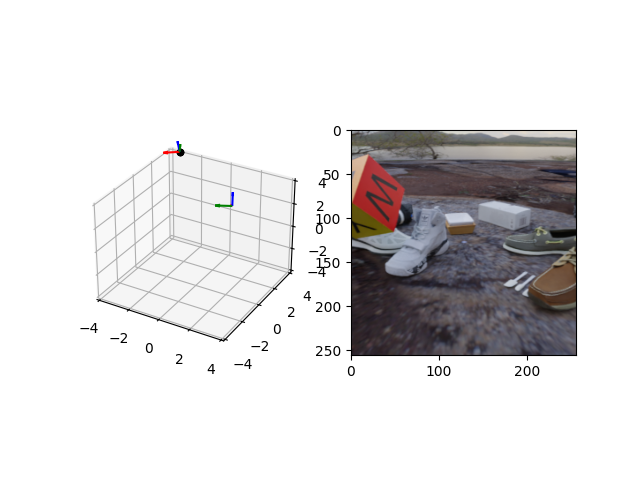

In [ ]:
# Plot the cube axes in world frame for the first pose in the trajectory.
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib widget

plt.close("all")

fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')

# Plot the GT pose.
gt_poses = traj["object_poses"]
gt_pose = gt_poses[1]
gt_pose_np = gt_pose.matrix().numpy()

# Plot arrows for the GT pose.
for (ii, c) in zip([0, 1, 2],  ["r", "g", "b"]):
    axis = np.zeros(3)
    axis[ii] = 1
    axis_wf = gt_pose_np[:3, :3] @ axis
    ax.quiver(gt_pose_np[0, 3], gt_pose_np[1, 3], gt_pose_np[2, 3], axis_wf[0], axis_wf[1], axis_wf[2], color=c)


print(gt_poses[0].matrix().numpy())

# Scatter the camera pose.
camera_pose = traj["camera_poses"][0].double()
camera_pose_np = camera_pose.matrix().numpy()


for (ii, c) in zip([0, 1, 2],  ["r", "g", "b"]):
    axis = np.zeros(3)
    axis[ii] = 1
    axis_wf = camera_pose_np[:3, :3] @ axis
    ax.quiver(camera_pose_np[0, 3], camera_pose_np[1, 3], camera_pose_np[2, 3], axis_wf[0], axis_wf[1], axis_wf[2], color=c)
    ax.scatter(camera_pose_np[0, 3], camera_pose_np[1, 3], camera_pose_np[2, 3], color="k")
# Set axes equal.
scale = 4
ax.set_xlim(-scale, scale)
ax.set_ylim(-scale, scale)
ax.set_zlim(-scale, scale)

# Imshow the image.
ax = fig.add_subplot(1, 2, 2)
ax.imshow(traj["images"][0].permute(1, 2, 0).numpy())

In [23]:
dt = 1e-1

pose0 = scenario.pose(0)
pose1 = scenario.pose(dt)
vel0 = scenario.velocity_n(0)
ang_vel0 = scenario.omega_b(0)
vel0 = pose0.rotation().unrotate(vel0) # Put velocity into body frame


twist0 = np.concatenate([ang_vel0, vel0])

dpose0 = gtsam.Pose3.Expmap(twist0 * dt)
pose1_pred = pose0 * dpose0


# error_handwritten = pose1_pred.localCoordinates(pose1)
error_handwritten = gtsam.Pose3.Logmap(pose1_pred.between(pose1))

# Now check against dynamics factor.
dynamics_factor = PoseDynamicsFactor(X(0), W(0), V(0), X(1), process_noise_pose, dt, vel_frame="world")
values = gtsam.Values()
values.insert(X(0), pose0)
values.insert(V(0), vel0)
values.insert(W(0), ang_vel0)
values.insert(X(1), pose1)
error_factor = PoseDynamicsFactor.error_func(dynamics_factor, values, dt=dt)

error_handwritten, error_factor

(array([1.38777878e-17, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]),
 array([1.38777878e-17, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]),
 array([-0.01165323, -0.00244564, -0.00393585]),
 array([-0.01161468, -0.00260178, -0.00395076]))

In [218]:
# Check up on translation stuff.
x0 = pose0.translation()
x1 = pose1.translation()

pose1_pred.translation(), x0 + vel0 * dt

(array([-1.01957706, -0.97943544, -1.68249092]),
 array([-1.0897015 , -0.97842765, -1.63847779]))

In [ ]:
# Try again but use Pose3 Between factor instead of Pose3 Dynamics factor.
# Quick example: 3D pose estimation with constant twist scenario.


# Setup scenario.
vel = np.array([0.1, 0, 0])
ang_vel = np.array([math.radians(30), -math.radians(30), 0])
vel_cov = np.array([1e-1, 1e-1, 1e-1]) * 1e2
ang_vel_cov = np.array([1e-1, 1e-1, 1e-1])
noisy_vel = vel + np.sqrt(vel_cov) * np.random.randn(3)
noisy_ang_vel = ang_vel + np.sqrt(ang_vel_cov) * np.random.randn(3)

# Create random initial pose.
prior_cov = np.diag(np.array([1e-1, 1e-1, 1e-1, 1e0, 1e0, 1e0]))
init_pose = gtsam.Pose3().expmap(np.linalg.cholesky(prior_cov) @ np.random.randn(6))

# Create process and measurement noises.
process_noise_pose = gtsam.noiseModel.Diagonal.Sigmas(25 * np.array([1e-1, 1e-1, 1e-1, 1e-1, 1e-1, 1e-1]))
meas_noise = gtsam.noiseModel.Diagonal.Sigmas(5e1 * np.array([1e-1, 1e-1, 1e-1, 1e-1, 1e-1, 1e-1]))

# Create scenario.
scenario = gtsam.ConstantTwistScenario(noisy_ang_vel, noisy_vel, init_pose)
dt = 1e-1
n_steps = 150

# Create a factor graph
graph = gtsam.NonlinearFactorGraph()
initial_estimate = gtsam.Values()

# Create ISAM.
parameters = gtsam.ISAM2Params()
isam = gtsam.ISAM2(parameters)

# Create a prior on the initial position
prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.diag(prior_cov))
graph.push_back(gtsam.PriorFactorPose3(X(0), gtsam.Pose3(), prior_noise))

# Initialize values with the prior.
initial_estimate.insert(X(0), init_pose)

# Solve to check we can recover the prior.
isam.update(graph, initial_estimate)
result = isam.calculateEstimate()
initial_estimate.clear()

noisy_poses = []

def add_factors(graph, initial_estimate, ii):
    curr_time = ii * dt

    # Simulate dynamics.
    pose = scenario.pose(curr_time)

    # Add a random measurement.
    noisy_pose = pose.compose(gtsam.Pose3().expmap(np.sqrt(meas_noise.sigmas()) * np.random.randn(6)))

    noisy_poses.append(noisy_pose)

    # Update the initial values.
    initial_estimate.insert(X(ii), noisy_pose)

    # Create a dynamics factor and add it to the graph.
    dynamics_factor = gtsam.BetweenFactorPose3(X(ii-1), X(ii), gtsam.Pose3(), process_noise_pose)
    graph.push_back(dynamics_factor)

    # Create a measurement factor and add it to the graph.
    meas_factor = gtsam.PriorFactorPose3(X(ii), noisy_pose, meas_noise)
    graph.push_back(meas_factor)

# Run loop to simulate the scenario.
for ii in range(1, n_steps):
    
    # Add new factors to graph
    %time add_factors(graph, initial_estimate, ii)

    # # Update the ISAM.
    %time isam.update(graph, initial_estimate)
    %time result = isam.calculateEstimate()
    initial_estimate.clear()
    


CPU times: user 46 µs, sys: 28 µs, total: 74 µs
Wall time: 63.2 µs
CPU times: user 28 µs, sys: 17 µs, total: 45 µs
Wall time: 48.2 µs
CPU times: user 8 µs, sys: 4 µs, total: 12 µs
Wall time: 13.8 µs
CPU times: user 33 µs, sys: 20 µs, total: 53 µs
Wall time: 52.7 µs
CPU times: user 35 µs, sys: 22 µs, total: 57 µs
Wall time: 60.6 µs
CPU times: user 8 µs, sys: 5 µs, total: 13 µs
Wall time: 15 µs
CPU times: user 77 µs, sys: 0 ns, total: 77 µs
Wall time: 57.5 µs
CPU times: user 70 µs, sys: 0 ns, total: 70 µs
Wall time: 73.4 µs
CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 15.5 µs
CPU times: user 66 µs, sys: 0 ns, total: 66 µs
Wall time: 51 µs
CPU times: user 85 µs, sys: 0 ns, total: 85 µs
Wall time: 89.4 µs
CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 16.9 µs
CPU times: user 63 µs, sys: 0 ns, total: 63 µs
Wall time: 51 µs
CPU times: user 103 µs, sys: 0 ns, total: 103 µs
Wall time: 106 µs
CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 17.4 µs
CPU times: us

In [ ]:
import gtsam_unstable

n_steps = 500
lag = 5.0
smoother = gtsam_unstable.BatchFixedLagSmoother(lag)
new_factors = gtsam.NonlinearFactorGraph()
new_values = gtsam.Values()
new_timestamps = gtsam_unstable.FixedLagSmootherKeyTimestampMap()

# First setup the prior factors.
# Create a prior on the initial position
prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([dt * 1e0 ]*6))
new_factors.push_back(gtsam.PriorFactorPose3(X(0), gtsam.Pose3(), prior_noise))

# Create measurement noise.
meas_noise = gtsam.noiseModel.Diagonal.Sigmas(1e1 * np.array([1e-1, 1e-1, 1e-1, 1e-1, 1e-1, 1e-1]))

# Initialize values with the prior.
new_values.insert(X(0), gtsam.Pose3())
new_timestamps.insert((X(0), 0.0))

pose_ests = []
measurements = []

for ii in range(1, n_steps):
    curr_time = ii * dt

    # Assign timestame to the current values.
    new_timestamps.insert((X(ii), curr_time))

    # Add new factors to graph
    # Simulate dynamics.
    pose = scenario.pose(curr_time)

    # Add a random measurement.
    noisy_pose = pose.compose(gtsam.Pose3().expmap(np.sqrt(meas_noise.sigmas()) * np.random.randn(6)))

    # Update the initial values.
    new_values.insert(X(ii), noisy_pose)

    # Create a dynamics factor and add it to the graph.
    if ii > 1:
        # Init with a finite-difference estimate of the velocity. 
        twist_est = result.atPose3(X(ii-2)).between(result.atPose3(X(ii-1)))
        dynamics_factor = gtsam.BetweenFactorPose3(X(ii-1), X(ii), twist_est,  process_noise_pose)
        new_factors.push_back(dynamics_factor)
    else:
        dynamics_factor = gtsam.BetweenFactorPose3(X(ii-1), X(ii), gtsam.Pose3(), process_noise_pose)
        new_factors.push_back(dynamics_factor)

    # Create a measurement factor and add it to the graph.
    meas_factor = gtsam.PriorFactorPose3(X(ii), noisy_pose, meas_noise)
    new_factors.push_back(meas_factor)

    # Update the smoother.
    %time smoother.update(new_factors, new_values, new_timestamps)
    # %time smoother.calculateEstimate().atPose3(X(ii))
    new_timestamps.clear()
    new_factors.resize(0)
    new_values.clear()

    result = smoother.calculateEstimate()

    # Store the pose estimate.
    pose_ests.append(result.atPose3(X(ii)))
    measurements.append(noisy_pose)

CPU times: user 210 µs, sys: 16 µs, total: 226 µs
Wall time: 230 µs
CPU times: user 254 µs, sys: 19 µs, total: 273 µs
Wall time: 277 µs
CPU times: user 326 µs, sys: 26 µs, total: 352 µs
Wall time: 355 µs
CPU times: user 418 µs, sys: 0 ns, total: 418 µs
Wall time: 422 µs
CPU times: user 527 µs, sys: 0 ns, total: 527 µs
Wall time: 531 µs
CPU times: user 204 µs, sys: 0 ns, total: 204 µs
Wall time: 207 µs
CPU times: user 231 µs, sys: 0 ns, total: 231 µs
Wall time: 234 µs
CPU times: user 794 µs, sys: 0 ns, total: 794 µs
Wall time: 797 µs
CPU times: user 887 µs, sys: 14 µs, total: 901 µs
Wall time: 904 µs
CPU times: user 1.1 ms, sys: 0 ns, total: 1.1 ms
Wall time: 1.11 ms
CPU times: user 1.14 ms, sys: 0 ns, total: 1.14 ms
Wall time: 1.15 ms
CPU times: user 909 µs, sys: 0 ns, total: 909 µs
Wall time: 912 µs
CPU times: user 1.33 ms, sys: 0 ns, total: 1.33 ms
Wall time: 1.34 ms
CPU times: user 475 µs, sys: 0 ns, total: 475 µs
Wall time: 480 µs
CPU times: user 1.23 ms, sys: 0 ns, total: 1.23 ms
